#### Summary:
After confirming all the correct credible sets to use (and making a few pseudo-credible sets), I'm going to do the final FINRICH runs for Figure 4 here. 
- Trait associated peaks (nominal sig, can use bed files in Kyle's dir to be safe?)
- Significant caQTL peaks (all cREs with 1/+ significant SNPs for each cell type, and cell type specific ones based on mashR outputs)

Based on code from this notebook: `/nfs/lab/hmummey/multiomic_islet/notebooks/cRE-gene_links_notebooks/5d_Links_Methods_FINRICH.ipynb` --> will also rerun this with final bed files :)

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(ggplot2))
suppressMessages(library(data.table))
suppressMessages(library(ggrepel))
suppressMessages(library(vroom))
suppressMessages(library(parallel))

# Set up

In [2]:
cell_types <- c('acinar','alpha','beta','bulk','delta','ductal','endothelial','gamma','immune','stellate')
major_celltypes <- c('beta','alpha','delta','gamma','acinar','ductal')

In [3]:
# Set up color palettes
major_colors = c('acinar'='#09850B', 'alpha'='#F51646', 'beta'='#3F98E0',
                 'delta'='#FFA946', 'ductal'='#F5DE6C', 'endothelial'='#752BBA', 
                 'gamma'='#A1D99B', 'immune'='#F598C9', 'stellate'='#AB7345')

In [4]:
fig_dir <- '/nfs/lab/welison/islet_multiome/intermediates/caQTLs/231026_WE_caQTLs/figures/'
# outdir <- '/nfs/lab/projects/multiomic_islet/outputs/genotypes/240627_caQTL_FINRICH'
outdir <- '/nfs/lab/projects/multiomic_islet/outputs/genotypes/240701_final_FINRICH'

In [5]:
#final credible set files!
credset_dir <- '/nfs/lab/projects/multiomic_islet/references/hg38_GWAS/credsets'
t1d_fp <- file.path(credset_dir,'T1D_Chiou_2021_cred_set.bed')
t2d_fp <- file.path(credset_dir,'T2D_DIAMANTE_multiancestry.cred99.hg38.bed')
glu2h_fp <- file.path(credset_dir,'2hGlu_MAGIC_trans_ancestry_pseudo_credset.LDproxyRsq0.8.bed')
fg_fp <- file.path(credset_dir,'FG_MAGIC_trans_ancestry_pseudo_credset.LDproxyRsq0.8.bed')
fi_fp <- file.path(credset_dir,'FI_MAGIC_trans_ancestry_pseudo_credset.LDproxyRsq0.8.bed')
hba1c_fp <- file.path(credset_dir,'HbA1c_MAGIC_trans_ancestry_pseudo_credset.LDproxyRsq0.8.bed')

In [6]:
gwas_prefixes <- c('T1D','T2D','2hGlu','FG','FI','HbA1c')
gwas_fps <- c(t1d_fp, t2d_fp, glu2h_fp, fg_fp, fi_fp, hba1c_fp)
names(gwas_fps) <- gwas_prefixes

In [7]:
peak_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/call_peaks/recluster_final_majorCTs_v2'

# Trait associated cREs

## Collect sets of cREs for FINRICH
Use outputs Kyle made, found here: `/nfs/lab/KG/islet_multiome/May2024/{$celltype}_{$trait}.{$dir}.p01.bed`

## Run FINRICH on sets of trait associated cREs

In [7]:
### Function to run FINRICH on all sets of sig results (will just use files from GREAT)
### similar to great I'm going to just write all the commands to a script and then run that in the terminal
run_FINRICH <- function(finemap_bed, prefix, cre_bed, bg_bed, out_dir){
    #create overall output file
    overall_out_fp <- file.path(out_dir,'combined_results.txt')
    
    #set up finrich code
    temp_fp <- file.path(out_dir, paste0(prefix,'_temp.txt'))
    cmd <- sprintf('finrich %s %s %s --permutations 1000 --processes 2 > %s', finemap_bed, cre_bed, bg_bed, temp_fp)
    # print(cmd)
    system(cmd)

    #concat and reformat outputs slightly
    cmd2 <- sprintf('awk -v prefix=%s \'NR == 1 {print prefix "|" $0;}\' %s >> %s', prefix, temp_fp, overall_out_fp)
    # print(cmd2)
    system(cmd2)
    system(sprintf('rm %s',temp_fp))
}

In [9]:
### Function to run FINRICH on a cell type (so I can parallelize by cell type)
run_finrich_trait_assoc_cres <- function(celltype, trait, cre_dir, gwas_prefix, gwas_fp, outdir){
    #set up file paths
    gwas_dir <- file.path(outdir,gwas_prefix)
    dir.create(gwas_dir, showWarnings=F, recursive=T)
    
    #collect necessary file paths for finrich
    fp <- file.path(cre_dir, sprintf('%s_%s.p01.bed',celltype, trait))
    bg_peaks <- file.path(cre_dir, sprintf('%s_%s.all.bed',celltype, trait))
    
    #run finrich with helper function
    run_FINRICH(gwas_fp, paste(celltype,trait,sep='-'), fp, bg_peaks, gwas_dir)
}

In [10]:
trait_cre_outdir <- file.path(outdir,'trait_assoc_cREs_FINRICH')
dir.create(trait_cre_outdir, showWarnings=F)

In [10]:
kg_dir <- '/nfs/lab/KG/islet_multiome/May2024'
kg_traits <- c('age','BMI','HbA1c','sex')

In [21]:
for(gwas_prefix in names(gwas_fps)){
    print(paste(gwas_prefix, Sys.time()))
    gwas_fp <- gwas_fps[[gwas_prefix]]

    for(trait in kg_traits){
        mclapply(major_celltypes, run_finrich_trait_assoc_cres, trait, kg_dir, gwas_prefix, gwas_fp, trait_cre_outdir)
    }
}

[1] "T1D"              "1719944928.62769"
[1] "T2D"              "1719945483.56098"
[1] "2hGlu"            "1719945587.26309"
[1] "FG"               "1719945614.01858"
[1] "FI"               "1719945659.58167"
[1] "HbA1c"            "1719945692.64532"


In [18]:
#rerun with different background file for age... somehow this file doesn't exist in the dir
dir2 <- file.path(outdir,'age_bg_cres')
deseq_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/DESeq/scaled_age'

for(celltype in major_celltypes){
    fp <- file.path(deseq_dir, sprintf('ATAC_deseq_v4.scaled_age.%s.tsv',celltype))
    df <- read.table(fp, sep='\t', header=1)
    bed <- as.data.frame(str_split_fixed(row.names(df), '-', 3)) %>% 
            mutate_at('V2', as.numeric) %>% arrange(V1,V2)
    out_fp <- file.path(dir2,sprintf('%s_age.all.bed',celltype))
    write.table(bed, out_fp, sep='\t', row.names=F, col.names=F, quote=F)
}

In [19]:
#rerun just for age associations LOL
for(gwas_prefix in names(gwas_fps)){
    print(paste(gwas_prefix, Sys.time()))
    gwas_fp <- gwas_fps[[gwas_prefix]]
    mclapply(major_celltypes, run_finrich_trait_assoc_cres, 'age', dir2, gwas_prefix, gwas_fp, trait_cre_outdir)
}

[1] "T1D 2024-07-03 10:15:39"
[1] "T2D 2024-07-03 10:17:55"
[1] "2hGlu 2024-07-03 10:18:22"
[1] "FG 2024-07-03 10:18:29"
[1] "FI 2024-07-03 10:18:40"
[1] "HbA1c 2024-07-03 10:18:48"


# caQTL cREs

## Collect sets of cREs for FINRICH
- Make sure peak was called in the cell type, otherwise we didn't even test it and thus it shouldn't be used

In [11]:
caqtl_cres_fp <- '/nfs/lab/projects/multiomic_islet/outputs/genotypes/240521_caQTL_GWAS_coloc_cts/fin_ct_specificity/all_RASQUAL_caQTL_features_ct_specificity.txt'
caqtl_cres <- read.table(caqtl_cres_fp, sep='\t', header=1)
head(caqtl_cres, n=2)

,cre,sig_caqtls_num_cts,sig_caqtls_cts,sig_caqtls_cts_spec,mash_num_cts,mash_cts,mash_cts_spec,peak_num_cts,peak_cts,peak_ct_spec,cpm5_num_cts,cpm5_cts,cpm5_ct_spec,cpm10_num_cts,cpm10_cts,cpm10_ct_spec,entropy2_celltype
,<chr>,<int>,<chr>,<lgl>,<int>,<chr>,<lgl>,<int>,<chr>,<lgl>,<int>,<chr>,<lgl>,<int>,<chr>,<lgl>,<chr>
1,chr10:100006062-100006793,2,"beta, bulk",FALSE,NA,NA,NA,4,"alpha, delta, gamma, ductal",FALSE,3,"alpha, gamma, ductal",FALSE,NA,NA,NA,NA
2,chr10:100009188-100010635,NA,NA,NA,NA,NA,NA,6,"beta, alpha, delta, gamma, acinar, ductal",FALSE,6,"beta, alpha, delta, gamma, acinar, ductal",FALSE,6,"beta, alpha, delta, gamma, acinar, ductal",FALSE,NA


In [13]:
#for each cell type collect all cres with a sig caQTL and all cres with specific mashR caqtl
cre_dir <- file.path(outdir,'caqtl_cres')
dir.create(cre_dir, showWarnings = F)

for(celltype in major_celltypes){
    #first subset to all sig caqtls (AND IF PEAK WAS EVEN CALLED IN CT) and write cres to a file
    sig_caqtls1 <- subset(caqtl_cres, grepl(celltype, sig_caqtls_cts) & grepl(celltype, peak_cts))
    bed1 <- as.data.frame(str_split_fixed(sig_caqtls1$cre, ':|-', 3))
    out_fp1 <- file.path(cre_dir, sprintf('%s_all_sig_caQTL_cREs.bed',celltype))
    write.table(bed1, out_fp1, sep='\t', row.names=F, col.names=F, quote=F)

    sig_caqtls2 <- subset(caqtl_cres, mash_cts==celltype)
    bed2 <- as.data.frame(str_split_fixed(sig_caqtls2$cre, ':|-', 3))
    out_fp2 <- file.path(cre_dir, sprintf('%s_ct_spec_caQTL_cREs.bed',celltype))
    write.table(bed2, out_fp2, sep='\t', row.names=F, col.names=F, quote=F)
}

## 7/25/24: Collect shared and lineage specific caQTL cREs

In [49]:
mash <- data.frame(fread('/nfs/lab/welison/islet_multiome/intermediates/caQTLs/231026_WE_caQTLs/anova_interaction/240111_WE_run1_all_ash_pca_canonical_mash_lfsr.tsv', sep='\t'))
row.names(mash) <- mash$V1
mash_fin <- as.data.frame(mash[,seq(2,7)] < 0.05)
mash_fin$cre <- stringr::str_split(row.names(mash_fin), '::', simplify=T)[,1]

upset_data <- group_by(mash_fin, cre) %>%
    summarise_all(any) %>%
    tibble::column_to_rownames(var='cre') %>%
    mutate_all(as.numeric)
head(upset_data)

Warning message in fread("/nfs/lab/welison/islet_multiome/intermediates/caQTLs/231026_WE_caQTLs/anova_interaction/240111_WE_run1_all_ash_pca_canonical_mash_lfsr.tsv", :
“Detected 6 column names but the data has 7 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


,acinar,alpha,beta,delta,ductal,gamma
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1:100036775-100037124,0,0,0,0,0,0
chr1:100037591-100039086,0,0,0,0,0,0
chr1:100046104-100046480,0,0,0,0,0,0
chr1:100046883-100047599,0,0,0,0,0,0
chr1:100050187-100050403,0,0,0,0,0,0
chr1:100053889-100054089,0,0,0,0,0,0


In [85]:
endo_cres <- row.names(subset(upset_data, beta==1 & alpha==1 & delta==1 & gamma==1 & acinar==0 & ductal==0))
exo_cres <- row.names(subset(upset_data, beta==0 & alpha==0 & delta==0 & gamma==0 & acinar==1 & ductal==1))
shared_cres <- row.names(subset(upset_data, beta==1 & alpha==1 & delta==1 & gamma==1 & acinar==1 & ductal==1))
lineage_cres <- list('endo'=endo_cres, 'exo'=exo_cres, 'shared'=shared_cres)
lapply(lineage_cres, length)

$endo
[1] 860

$exo
[1] 4

$shared
[1] 4545

In [94]:
cre_dir <- file.path(outdir,'caqtl_cres')

#write these to files
for (ct_set in names(lineage_cres)){
    cres <- lineage_cres[[ct_set]]
    chroms <- str_split_fixed(cres, ':', 2)[,1]
    coords <- str_split_fixed(str_split_fixed(cres, ':', 2)[,2], '-',2)
    bed <- as.data.frame(cbind(chroms, coords))

    bed_fp <- file.path(cre_dir, sprintf('%s_ct_spec_caQTL_cREs.bed',ct_set))
    write.table(bed, bed_fp, sep='\t', row.names=F, col.names=F, quote=F) 
}

## Run FINRICH on sets of caQTL cREs

In [91]:
### Function to run FINRICH on all sets of sig results (will just use files from GREAT)
### similar to great I'm going to just write all the commands to a script and then run that in the terminal
run_FINRICH <- function(finemap_bed, prefix, cre_bed, bg_bed, out_dir){
    #create overall output file
    overall_out_fp <- file.path(out_dir,'combined_results.txt')
    
    #set up finrich code
    temp_fp <- file.path(out_dir, paste0(prefix,'_temp.txt'))
    cmd <- sprintf('finrich %s %s %s --permutations 1000 --processes 2 > %s', finemap_bed, cre_bed, bg_bed, temp_fp)
    # print(cmd)
    system(cmd)

    #concat and reformat outputs slightly
    cmd2 <- sprintf('awk -v prefix=%s \'NR == 1 {print prefix "|" $0;}\' %s >> %s', prefix, temp_fp, overall_out_fp)
    # print(cmd2)
    system(cmd2)
    system(sprintf('rm %s',temp_fp))
}

In [101]:
### Function to run FINRICH on a cell type (so I can parallelize by cell type)
run_finrich_all_caqtls <- function(celltype, cre_dir, gwas_prefix, gwas_fp, outdir){
    #set up file paths
    gwas_dir <- file.path(outdir,gwas_prefix)
    dir.create(gwas_dir, showWarnings=F, recursive=T)
    
    #collect necessary file paths for finrich
    # fp1 <- file.path(cre_dir, sprintf('%s_all_sig_caQTL_cREs.bed',celltype))
    fp2 <- file.path(cre_dir, sprintf('%s_ct_spec_caQTL_cREs.bed',celltype))
    
    #run finrich with helper function
    if(celltype %in% c('endo','exo','shared')){
        ct_peaks <- file.path(peak_dir, 'mergedPeak.txt')
    } else {
        ct_peaks <- file.path(peak_dir, sprintf('%s.merged_peaks.anno.mergedOverlap.bed',celltype))    
    }
    # run_FINRICH(gwas_fp, paste('all_sig',celltype,sep='-'), fp1, ct_peaks, gwas_dir)
    run_FINRICH(gwas_fp, paste('ct_spec',celltype,sep='-'), fp2, ct_peaks, gwas_dir)
}

In [93]:
caqtl_cre_outdir <- file.path(outdir,'caQTL_cREs_FINRICH2')
cre_dir <- file.path(outdir,'caqtl_cres')

In [102]:
celltypes_to_run <- c(major_celltypes, 'endo', 'exo', 'shared')
celltypes_to_run

[1] "beta"   "alpha"  "delta"  "gamma"  "acinar" "ductal" "endo"   "exo"   
[9] "shared"

In [97]:
for(gwas_prefix in names(gwas_fps)){
    print(paste(gwas_prefix, Sys.time()))
    gwas_fp <- gwas_fps[[gwas_prefix]]
    mclapply(celltypes_to_run, run_finrich_all_caqtls, cre_dir, gwas_prefix, gwas_fp, caqtl_cre_outdir)
}

[1] "T1D 2024-07-25 13:12:04"
[1] "T2D 2024-07-25 13:26:04"
[1] "2hGlu 2024-07-25 13:29:15"
[1] "FG 2024-07-25 13:29:31"
[1] "FI 2024-07-25 13:30:32"
[1] "HbA1c 2024-07-25 13:31:10"


In [103]:
#rerun on lineage caQTL cREs, with new background (all peaks)
lineages <- c('endo','exo','shared')

for(gwas_prefix in names(gwas_fps)){
    print(paste(gwas_prefix, Sys.time()))
    gwas_fp <- gwas_fps[[gwas_prefix]]
    mclapply(lineages, run_finrich_all_caqtls, cre_dir, gwas_prefix, gwas_fp, caqtl_cre_outdir)
}

[1] "T1D 2024-07-26 10:36:07"
[1] "T2D 2024-07-26 10:46:58"
[1] "2hGlu 2024-07-26 10:52:40"
[1] "FG 2024-07-26 10:53:00"
[1] "FI 2024-07-26 10:54:15"
[1] "HbA1c 2024-07-26 10:54:56"


## For context just overlap caQTL cREs with credible sets)

In [22]:
### Function to run FINRICH on all sets of sig results (will just use files from GREAT)
### similar to great I'm going to just write all the commands to a script and then run that in the terminal
check_overlap <- function(finemap_bed, bed_fp, log_fp){
    system(sprintf('echo %s >> %s', bed_fp, log_fp))
    cmd <- sprintf('bedtools intersect -a %s -b %s -wa -wb | wc -l >> %s', bed_fp, finemap_bed, log_fp)
    system(cmd)
}

In [23]:
log_dir <- file.path(caqtl_cre_outdir,'credset_overlaps')
dir.create(log_dir, showWarnings=FALSE)

In [24]:
gwas_prefix <- 'T1D'
gwas_fp <- t1d_fp

for (celltype in major_celltypes){
    #overlap all sig caqtl cres
    log1 <- file.path(log_dir,sprintf('all_ct_sig_caQTL.%s_overlap.txt',gwas_prefix))
    fp1 <- file.path(cre_dir, sprintf('%s_all_sig_caQTL_cREs.bed',celltype))
    check_overlap(gwas_fp, fp1, log1)

    #overlap the ct spec caqtl cres (probably too few)
    log2 <- file.path(log_dir,sprintf('ct_spec_caQTL.%s_overlap.txt',gwas_prefix))
    fp2 <- file.path(cre_dir, sprintf('%s_ct_spec_caQTL_cREs.bed',celltype))
    check_overlap(gwas_fp, fp2, log2)
}

In [25]:
gwas_prefix <- 'T2D'
gwas_fp <- t2d_fp

for (celltype in major_celltypes){
    #overlap all sig caqtl cres
    log1 <- file.path(log_dir,sprintf('all_ct_sig_caQTL.%s_overlap.txt',gwas_prefix))
    fp1 <- file.path(cre_dir, sprintf('%s_all_sig_caQTL_cREs.bed',celltype))
    check_overlap(gwas_fp, fp1, log1)

    #overlap the ct spec caqtl cres (probably too few)
    log2 <- file.path(log_dir,sprintf('ct_spec_caQTL.%s_overlap.txt',gwas_prefix))
    fp2 <- file.path(cre_dir, sprintf('%s_ct_spec_caQTL_cREs.bed',celltype))
    check_overlap(gwas_fp, fp2, log2)
}

In [26]:
gwas_prefix <- '2hGlu'
gwas_fp <- glu2h_fp

for (celltype in major_celltypes){
    #overlap all sig caqtl cres
    log1 <- file.path(log_dir,sprintf('all_ct_sig_caQTL.%s_overlap.txt',gwas_prefix))
    fp1 <- file.path(cre_dir, sprintf('%s_all_sig_caQTL_cREs.bed',celltype))
    check_overlap(gwas_fp, fp1, log1)

    #overlap the ct spec caqtl cres (probably too few)
    log2 <- file.path(log_dir,sprintf('ct_spec_caQTL.%s_overlap.txt',gwas_prefix))
    fp2 <- file.path(cre_dir, sprintf('%s_ct_spec_caQTL_cREs.bed',celltype))
    check_overlap(gwas_fp, fp2, log2)
}

In [27]:
gwas_prefix <- 'FI'
gwas_fp <- fi_fp

for (celltype in major_celltypes){
    #overlap all sig caqtl cres
    log1 <- file.path(log_dir,sprintf('all_ct_sig_caQTL.%s_overlap.txt',gwas_prefix))
    fp1 <- file.path(cre_dir, sprintf('%s_all_sig_caQTL_cREs.bed',celltype))
    check_overlap(gwas_fp, fp1, log1)

    #overlap the ct spec caqtl cres (probably too few)
    log2 <- file.path(log_dir,sprintf('ct_spec_caQTL.%s_overlap.txt',gwas_prefix))
    fp2 <- file.path(cre_dir, sprintf('%s_ct_spec_caQTL_cREs.bed',celltype))
    check_overlap(gwas_fp, fp2, log2)
}

In [30]:
gwas_prefix <- 'FG'
gwas_fp <- fg_fp

for (celltype in major_celltypes){
    #overlap all sig caqtl cres
    log1 <- file.path(log_dir,sprintf('all_ct_sig_caQTL.%s_overlap.txt',gwas_prefix))
    fp1 <- file.path(cre_dir, sprintf('%s_all_sig_caQTL_cREs.bed',celltype))
    check_overlap(gwas_fp, fp1, log1)

    #overlap the ct spec caqtl cres (probably too few)
    log2 <- file.path(log_dir,sprintf('ct_spec_caQTL.%s_overlap.txt',gwas_prefix))
    fp2 <- file.path(cre_dir, sprintf('%s_ct_spec_caQTL_cREs.bed',celltype))
    check_overlap(gwas_fp, fp2, log2)
}

In [31]:
gwas_prefix <- 'Hba1c'
gwas_fp <- hba1c_fp

for (celltype in major_celltypes){
    #overlap all sig caqtl cres
    log1 <- file.path(log_dir,sprintf('all_ct_sig_caQTL.%s_overlap.txt',gwas_prefix))
    fp1 <- file.path(cre_dir, sprintf('%s_all_sig_caQTL_cREs.bed',celltype))
    check_overlap(gwas_fp, fp1, log1)

    #overlap the ct spec caqtl cres (probably too few)
    log2 <- file.path(log_dir,sprintf('ct_spec_caQTL.%s_overlap.txt',gwas_prefix))
    fp2 <- file.path(cre_dir, sprintf('%s_ct_spec_caQTL_cREs.bed',celltype))
    check_overlap(gwas_fp, fp2, log2)
}

# 7/22/24: Also run FINRICH on entropy peaks!!

## First make bed files of all entropy peaks and overlap them with credible sets

In [20]:
#first read in entropy cREs and write to bed files
entropy_peak_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/entropy_outputs/ATAC_ct_spec_cREs'

for(celltype in cell_types[-4]){
    peak_fp <- file.path(entropy_peak_dir,sprintf('%s_entropy2_UNION_cREs_CPM5.txt',celltype))
    peaks <- fread(peak_fp)
    bed <- str_split_fixed(peaks$peak, '-', 3)
    bed_fp <- file.path(outdir,'entropy_cres',sprintf('%s_entropy2_UNION_cREs_CPM5.bed',celltype))
    write.table(bed, bed_fp, sep='\t', row.names=F, col.names=F, quote=F)
}

In [10]:
### Function to run FINRICH on all sets of sig results (will just use files from GREAT)
### similar to great I'm going to just write all the commands to a script and then run that in the terminal
check_overlap <- function(finemap_bed, bed_fp, log_fp){
    system(sprintf('echo %s >> %s', bed_fp, log_fp))
    cmd <- sprintf('bedtools intersect -a %s -b %s -wa -wb | wc -l >> %s', bed_fp, finemap_bed, log_fp)
    system(cmd)
}

In [21]:
entropy_cre_outdir <- file.path(outdir,'entropy_cREs_FINRICH')
log_dir <- file.path(entropy_cre_outdir,'credset_overlaps')
dir.create(log_dir, showWarnings=FALSE)

In [23]:
for (gwas_prefix in gwas_prefixes){
    gwas_fp <- gwas_fps[[gwas_prefix]]
    log1 <- file.path(log_dir,sprintf('all_ct_entropy_cREs.%s_overlap.txt',gwas_prefix))
    
    for(celltype in cell_types[-4]){
        #overlap all entropy cres
        fp1 <- file.path(outdir,'entropy_cres',sprintf('%s_entropy2_UNION_cREs_CPM5.bed',celltype))
        check_overlap(gwas_fp, fp1, log1)
    }
}

## Run FINRICH on entropy cREs

In [39]:
### Function to run FINRICH on all sets of sig results (will just use files from GREAT)
### similar to great I'm going to just write all the commands to a script and then run that in the terminal
run_FINRICH <- function(finemap_bed, prefix, cre_bed, bg_bed, out_dir){
    #create overall output file
    overall_out_fp <- file.path(out_dir,'combined_results.txt')
    
    #set up finrich code
    temp_fp <- file.path(out_dir, paste0(prefix,'_temp.txt'))
    cmd <- sprintf('finrich %s %s %s --permutations 1000 --processes 2 > %s', finemap_bed, cre_bed, bg_bed, temp_fp)
    # print(cmd)
    system(cmd)

    #concat and reformat outputs slightly
    cmd2 <- sprintf('awk -v prefix=%s \'NR == 1 {print prefix "|" $0;}\' %s >> %s', prefix, temp_fp, overall_out_fp)
    # print(cmd2)
    system(cmd2)
    system(sprintf('rm %s',temp_fp))
}

In [36]:
### Function to run FINRICH on a cell type (so I can parallelize by cell type)
run_finrich_entropy_cres <- function(celltype, cre_dir, gwas_prefix, gwas_fp, outdir){
    #set up file paths
    gwas_dir <- file.path(outdir,gwas_prefix)
    dir.create(gwas_dir, showWarnings=F, recursive=T)
    
    #collect necessary file paths for finrich
    fp <- file.path(cre_dir, sprintf('%s_entropy2_UNION_cREs_CPM5.bed',celltype))
    entropy_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/call_peaks/240304_union_peaks/celltype_union_peaks'
    bg_peaks <- file.path(entropy_dir, sprintf('%s.union_peaks.cut.bed',celltype))
    
    #run finrich with helper function
    run_FINRICH(gwas_fp, celltype, fp, bg_peaks, gwas_dir)
}

In [29]:
entropy_cre_outdir <- file.path(outdir,'entropy_cREs_FINRICH')
dir.create(entropy_cre_outdir, showWarnings=F)
entropy_cre_indir <- file.path(outdir,'entropy_cres')

In [40]:
for(gwas_prefix in names(gwas_fps)){
    print(paste(gwas_prefix, Sys.time()))
    gwas_fp <- gwas_fps[[gwas_prefix]]
    mclapply(major_celltypes, run_finrich_entropy_cres, entropy_cre_indir, gwas_prefix, gwas_fp, entropy_cre_outdir)
}

[1] "T1D 2024-07-23 10:42:23"
[1] "T2D 2024-07-23 11:15:57"
[1] "2hGlu 2024-07-23 11:23:24"
[1] "FG 2024-07-23 11:24:08"
[1] "FI 2024-07-23 11:26:28"
[1] "HbA1c 2024-07-23 11:27:36"


## Real quick plot the results (copied code from Figure 4 notebook)

In [41]:
### function to parse results from FINRICH
parse_finrich_res <- function(finrich_fp){
    df <- suppressMessages(vroom::vroom(finrich_fp, col_names=FALSE))
    
    #reformat everything with dplyr
    df <- df %>% select(X1,X2,X4,X6,X8,X10) %>%
            `colnames<-`(c('id','pval','fold_enrich','logOR','conf_lower','conf_upper'))
    df$id <- gsub('\\|\\{\\"pval\\":','',df$id)
    df$conf_upper <- as.numeric(gsub('}','',df$conf_upper))
    return(df)
}

In [42]:
# finrich_dir <- '/nfs/lab/KG/islet_multiome/May2024'
# kyle_cts <- c('beta','alpha','delta','gamma','ductal','acinar')
finrich_dir <- '/nfs/lab/projects/multiomic_islet/outputs/genotypes/240701_final_FINRICH/entropy_cREs_FINRICH'

finrich_res <- list()
for(study in gwas_prefixes){
    #parse in finrich results and reorganize a bit (add trait, gwas and ct info)
    fp <- file.path(finrich_dir, study, 'combined_results.txt')
    df <- parse_finrich_res(fp)
    df$gwas <- study
    df$celltype <- df$id
    finrich_res[[study]] <- df
}
data <- rbindlist(finrich_res)
data$qval <- p.adjust(data$pval, method='BH')
data$sig <- ifelse(data$qval < 0.1, '*', ifelse(data$pval<0.05,'\u00b0',''))

In [47]:
head(data)
subset(data, fold_enrich>0.2)

id,pval,fold_enrich,logOR,conf_lower,conf_upper,gwas,celltype,qval,sig
<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
beta,1.000,0.0000000,"-Infinity,","-Infinity,",-Inf,T1D,beta,1,
alpha,1.000,0.0000000,"-Infinity,","-Infinity,",-Inf,T1D,alpha,1,
delta,1.000,0.0000000,"-Infinity,","-Infinity,",-Inf,T1D,delta,1,
gamma,1.000,0.0000000,"-Infinity,","-Infinity,",-Inf,T1D,gamma,1,
acinar,0.452,0.1393685,"-1.981864656224035,","-4.176407727104108,",18.78873,T1D,acinar,1,
ductal,0.398,0.2100018,"-1.5696760420288052,","-3.7656841483682157,",19.90175,T1D,ductal,1,


id,pval,fold_enrich,logOR,conf_lower,conf_upper,gwas,celltype,qval,sig
<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
ductal,0.398,0.2100018,"-1.5696760420288052,","-3.7656841483682157,",19.90175,T1D,ductal,1,
ductal,0.348,0.2760273,"-1.2955017627046348,","-3.379828329811582,",15.38050,HbA1c,ductal,1,


Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


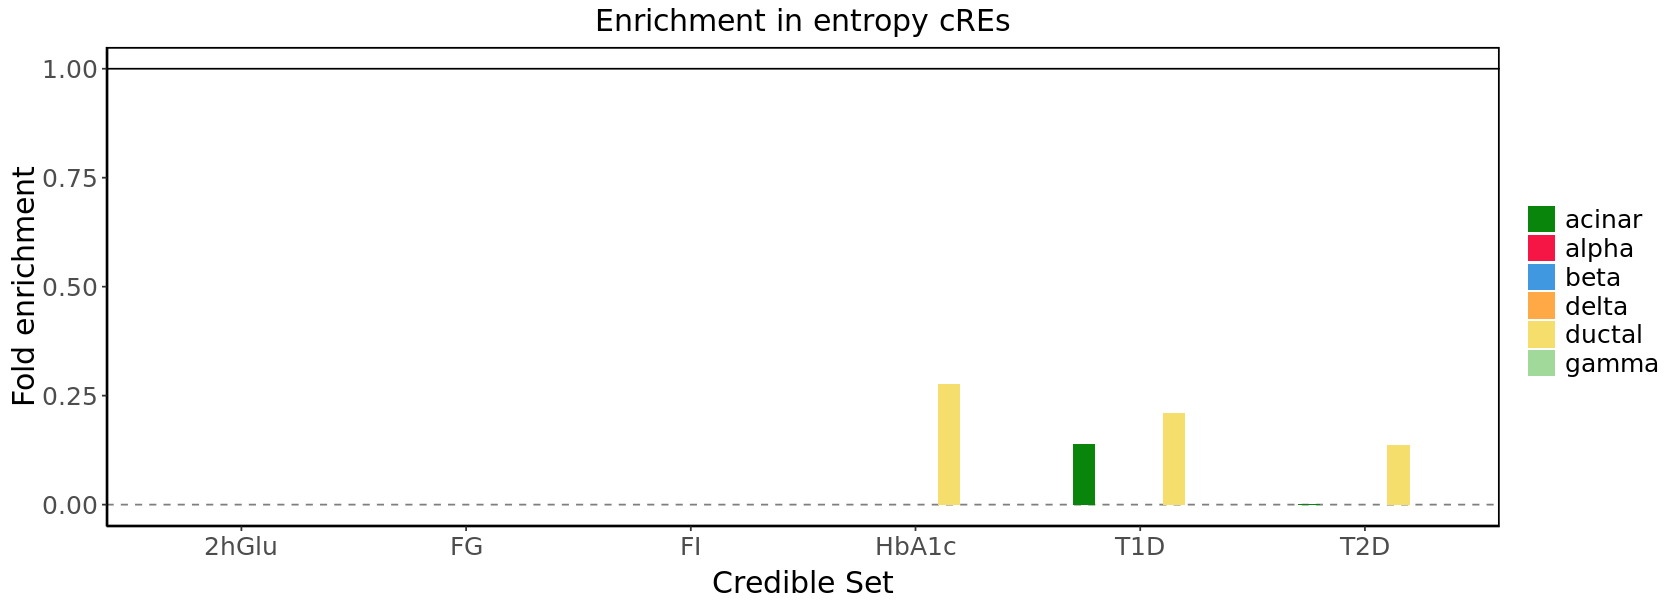

In [49]:
# Make a bar plot for each trait
# fp <- file.path(outdir, sprintf('4c_caQTL_%s_cRE_FINRICH.svg',peak_set))
# pdf(fp, width=14, height=5)

data_sub <- data
xmax <- ceiling(max(data_sub$fold_enrich) + 0.5)

options(repr.plot.width=14, repr.plot.height=5)
theme_set(theme_classic())
p1 <- ggplot(data=data_sub, aes(y=fold_enrich, x=gwas, fill=celltype)) + 
        geom_hline(yintercept=seq(0, xmax, 2.5), linetype='dashed', color='black', alpha=0.5, size=0.5) + 
        geom_bar(width=0.6, position=position_dodge(0.6), stat='identity') + 
        scale_fill_manual(values=major_colors) + 
        geom_hline(yintercept=1, color='black', size=0.5) + 
        geom_text(aes(gwas, fold_enrich, label=sig), size=10, position=position_dodge(0.6), vjust=0.25) +
        # xlim(0,xmax) + 
        ylab('Fold enrichment') + xlab('Credible Set') + labs(title='Enrichment in entropy cREs') + 
        theme(plot.title=element_text(size=18, hjust=0.5),
              axis.text.x=element_text(size=15, vjust=0.5),
              axis.text.y=element_text(size=15, vjust=0.5),
              axis.title.x = element_text(size=18, vjust=-0.35),
              axis.title.y = element_text(size=18, vjust=0.5),
              legend.text=element_text(size=15),
              legend.title=element_blank(),
              panel.border=element_rect(color='black',fill=NA, size=1))    
# p1$data$trait <- factor(x = p1$data$trait, levels=traits2)
# print(p1)
# dev.off()
print(p1)